In [4]:
from onix.data_tools import get_experiment_data
from onix.analysis.fitter import Fitter
from onix.analysis.helper import data_groups

import matplotlib.pyplot as plt
import numpy as np

%matplotlib ipympl

In [61]:
data_range = (81113, 96000)

In [62]:
def get_default_gaussian_fitter():
    def gaussian(f, f_0, a, sigma, b, c):
        numerator = (f - f_0) ** 2
        denominator = 2 * sigma ** 2
        return a * np.exp(-numerator / denominator) + c + b * (f - f_0)

    fitter = Fitter(gaussian)
    fitter.set_absolute_sigma(False)
    fitter.set_p0({"f_0": 0, "sigma": 0.3, "c": 1.0})
    return fitter


def analyze_data(data_number):
    data, headers = get_experiment_data(data_number)
    detunings = headers["detunings"].to("MHz").magnitude
    (chasm_avg, antihole_avg, rf_avg), (monitor_chasm_avg, monitor_antihole_avg, monitor_rf_avg) = data_groups(data, headers)

    try:
        ah_fit = get_default_gaussian_fitter()
        ah_fit.set_data(detunings, antihole_avg / chasm_avg)
        ah_fit.fit()
        return ah_fit, headers
    except Exception as e:
        return None, None


def is_correct_data(ah_fit):
    if ah_fit is None:
        return False
    if abs(ah_fit.results["f_0"]) > 0.5:
        return False
    if abs(ah_fit.results["sigma"]) > 0.6:
        return False
    if abs(ah_fit.results["c"] - 1) > 0.2:
        return False
    if abs(ah_fit.results["b"]) > 0.2:
        return False
    return True


def merit_function(ah_fit, antihole_time):
    height = ah_fit.results["a"]
    sigma = ah_fit.results["sigma"]
    return np.abs(sigma) * np.sqrt(antihole_time) / height ** 2  # objective to minimize

In [63]:
data_ids = []
ac_offsets = []
ca_offsets = []
ac_amplitudes = []
ca_amplitudes = []
ac_times = []
ca_times = []
ah_total_times = []
merit_results = []

for data_id in range(*data_range):
    ah_fit, headers = analyze_data(data_id)
    if is_correct_data(ah_fit):
        data_ids.append(data_id)
        ac_offsets.append(headers["params"]["eos"]["ac"]["offset"].to("MHz").magnitude)
        ca_offsets.append(headers["params"]["eos"]["ca"]["offset"].to("MHz").magnitude)
        ac_amplitudes.append(headers["params"]["antihole"]["amplitudes"][0])
        ca_amplitudes.append(headers["params"]["antihole"]["amplitudes"][1])
        ac_times.append(headers["params"]["antihole"]["times"][0].to("s").magnitude)
        ca_times.append(headers["params"]["antihole"]["times"][1].to("s").magnitude)
        ah_total_times.append(headers["params"]["antihole"]["total_time"].to("s").magnitude + ac_times[-1] + ca_times[-1])
        merit_results.append(merit_function(ah_fit, ah_total_times[-1]))

/home/icarus/.venv/vlab/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/icarus/.venv/vlab/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/icarus/.venv/vlab/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [64]:
filter = np.bitwise_and(np.bitwise_and(
    np.bitwise_and(
        np.array(ac_offsets) - np.array(ca_offsets) > -0.4,
        np.array(ac_offsets) - np.array(ca_offsets) < 0.2
    ),
    np.bitwise_and(
        np.array(ac_amplitudes) > 1700,
        np.array(ca_amplitudes) > 1700,
    )
),
                        np.array(ah_total_times) < 0.5)

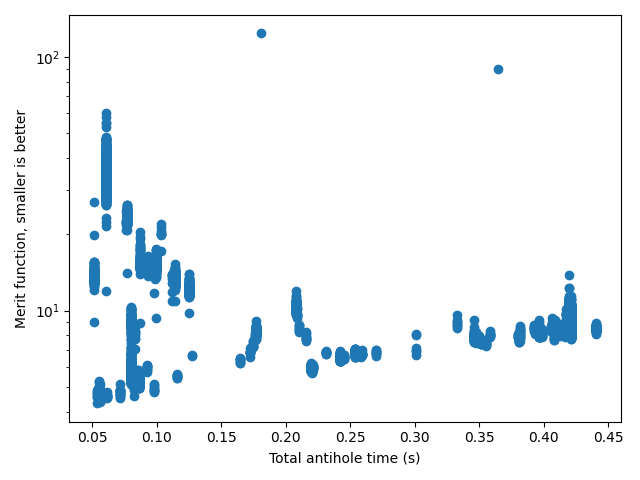

In [65]:
fig, ax = plt.subplots()
ax.scatter(np.array(ah_total_times)[filter], np.array(merit_results)[filter])
#ax.scatter(np.array(ca_amplitudes)[filter], np.array(merit_results)[filter], label="ac")
ax.set_yscale("log")
#ax.set_ylim(3, 20)
ax.set_ylabel("Merit function, smaller is better")
ax.set_xlabel("Total antihole time (s)")
plt.tight_layout()
plt.show()

In [55]:
list(np.array(merit_results)[np.array(ah_total_times) > 0.3]).index(min(np.array(merit_results)[np.array(ah_total_times) > 0.3]))

2969

In [56]:
np.array(data_ids)[np.array(ah_total_times) > 0.3][2969]

88718